<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    del Mini-Challenge 2 <br> 
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Si Ben Tran im HS 2023.<br>Bachelor of Science FHNW in Data Science.
</p>


Ziel:  
Vertiefung in ein eher aktuelles Paper aus der Forschung und Umsetzung eines darin beschriebenen oder verwandten Tasks - gemäss Vereinbarung mit dem Fachcoach. 

Beispiel:  
Implementiere, trainiere und validiere ein Deep Learning Modell für Image Captioning wie beschrieben im Paper Show and Tell.

Zeitlicher Rahmen:  
Wird beim Schritt 1 verbindlich festgelegt.

Beurteilung:  
Beurteilt wird auf Basis des abgegebenen Notebooks:  
•	Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung.  
•	Klare, gut-strukturierte Umsetzung.   
•	Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut kommentierten Plots und Tabellen.  
•	Vernünftiger Umgang mit (Computing-)Ressourcen.  
•	Verständliche Präsentation der Ergebnisse.  

Referenzen, Key Words  
•	Word Embedding (z.B. word2vec, glove), um Wörter in numerische Vektoren in einem geeignet dimensionierten Raum zu mappen. Siehe z.B. Andrew Ng, Coursera: [Link](https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s)      
•	Bild Embedding mittels vortrainierten (evt. retrained) Netzwerken wie beispielsweise ResNet, GoogLeNet, EfficientNet oder ähnlich Transfer-Learning.  
•	Seq2Seq Models bekannt für Sprach-Übersetzung. 

Daten:   
•	Gemäss Vereinbarung (für Captioning: [Flickr8k-Daten](https://www.kaggle.com/adityajn105/flickr8k/activity)).

•	Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll.
 

# 1 Setup und Imports

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# path setup
import os
os.chdir('../')

# Data Science Libraries
import tqdm 
from tqdm import tqdm 
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count

# Text Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from typing import List

# Torch
import torch
print(torch.__version__)
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset
from torchvision.models import ResNet18_Weights
from torchvision import models
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, ToPILImage, Normalize
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, ColorJitter
import pytorch_lightning as pl 


# Custom Modules
from src.gpu_setup import DeviceSetup
from src.flickerdataset import Flicker8kDataset




1.13.1+cu116


c:\Users\Ben\venvs\del\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device_setup = DeviceSetup(seed=42)
device_setup.setup()

Using device: cuda

NVIDIA GeForce GTX 980
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


---

# 2 Daten
Wir erkennen bei der Spalte *image*, das ein jpg. Bilddatei mehrere *catpion* hat.

Bei der Visualisierung der Bilder erkenne wir:
- Personen oder Tiere
- Unterschiedliche Grössen
- Unterschiedliche Auflösung


In [3]:
class DataExplorer:
    def __init__(self, image_path, captions_path):
        self.image_path = image_path
        self.data = pd.read_csv(captions_path)


    def _get_image_unique(self):
        """
        This method returns a list of unique image IDs.
        """
        image_unique = self.data['image'].unique()
        return image_unique
    
    def _get_word_counts(self):
        """
        This method returns a list of the number of words per caption.
        """
        word_counts = self.data['caption'].apply(str.split).apply(len)
        return word_counts
    
    def _read_image(self, image_id):
        """
        This method reads an image from a specific path and returns the image object.
        """
        image = Image.open(self.image_path + "/" + image_id)
        return image

    def _get_captions(self, image_id):
        """
        This method retrieves the captions associated with an image ID from the data dictionary.
        """
        captions = []
        for i in range(len(self.data)):
            if self.data['image'][i] == image_id:
                captions.append(self.data['caption'][i])
        captions = '\n'.join(captions)
        return captions

    def plot_n_m_image_caption(self, n, m):
        """
        This method plots a grid of n x m images along with their captions.
        """
        image_unique = self._get_image_unique()
        fig, ax = plt.subplots(n, m, figsize=(16, 20))
        for i in range(n):
            for j in range(m):
                index = np.random.randint(0, len(image_unique))
                image_id = image_unique[index]
                image = self._read_image(image_id)
                captions = self._get_captions(image_id)
                ax[i, j].imshow(np.asarray(image))
                ax[i, j].set_title(captions)
        plt.tight_layout()
        plt.show()

    def plot_image_size(self):
        """
        This method plots a grid of n x m images along with their captions.
        """
        image_unique = self._get_image_unique()
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        # set range of x and y axis
        ax.set_xlabel('width of image')
        ax.set_ylabel('height of image')
        for i in range(len(image_unique)):
            image_id = image_unique[i]
            image = self._read_image(image_id)
            width, height = image.size
            ax.scatter(width, height)
        ax.set_title('Distribution size of images')
        plt.tight_layout()
        plt.show()

    # plot caption distribution word length
    def plot_caption_distribution(self):
        """
        This method plots the distribution of the number of words per caption.
        """
        word_counts = self._get_word_counts()
        plt.figure(figsize=(12, 8))
        plt.hist(word_counts, bins=25, color = 'limegreen', edgecolor='black', linewidth=1.2)
        plt.title("Distribution of Number of Words per Caption")
        plt.xlabel("Number of Words")
        plt.ylabel("Frequency")
        plt.show()

    # get statistical summary of caption distribution word length
    def get_caption_distribution(self):
        """
        This method prints the statistical summary of the number of words per caption.
        """
        word_counts = self._get_word_counts()
        print(word_counts.describe(percentiles=[0.25, 0.5, 0.75, 0.95]))

    def plot_caption_ecdf(self):
        """
        This method plots the ECDF of the number of words per caption.
        """
        word_counts = self._get_word_counts()
        word_counts_sorted = word_counts.sort_values()
        y = np.arange(1, len(word_counts_sorted) + 1) / len(word_counts_sorted)  
        plt.figure(figsize=(12, 8))
        plt.plot(word_counts_sorted, y, color='limegreen')
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.axvline(x=19, color='r', linestyle='-')
        plt.xticks(np.arange(np.min(word_counts_sorted), np.max(word_counts_sorted), 1.0))
        plt.title("ECDF of Number of Words per Caption")
        plt.xlabel("Number of Words")
        plt.ylabel("Proportion")
        plt.show()

    # plot most commen words
    def plot_most_common_words(self):
        """
        This method plots the most common words in the captions.
        """
        from collections import Counter
        word_counts = self.data['caption'].apply(str.split).apply(Counter).sum()
        word_counts = pd.DataFrame.from_dict(word_counts, orient='index').reset_index()
        word_counts.columns = ['word', 'count']
        word_counts = word_counts.sort_values(by='count', ascending=False)
        plt.figure(figsize=(12, 8))
        plt.bar(word_counts['word'][:20], word_counts['count'][:20], color = 'limegreen', edgecolor='black', linewidth=1.2)
        plt.title("Most Common Words in Captions")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.show()

In [4]:
image_path = "data/Flickr8K/images/"
captions_path = "data/Flickr8K/captions.txt"

flicker_data_explorer = DataExplorer(image_path, captions_path)
flicker_data = flicker_data_explorer.data

## 2.1 Dataframe

In [5]:
flicker_data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


## 2.2 Visualisierungen der Bilder

In [6]:
#flicker_data_explorer.plot_n_m_image_caption(2, 2)

## 2.3 Grössen der Bilder

In [7]:
#flicker_data_explorer.plot_image_size()

## 2.4 Caption Länge

In [8]:
#flicker_data_explorer.plot_caption_distribution()
#flicker_data_explorer.plot_caption_ecdf()
#flicker_data_explorer.get_caption_distribution()

## 2.5 Häufigste Wörter

In [9]:
#flicker_data_explorer.plot_most_common_words()

---

# 3 Preprocessing der Bilder

Wir werden Die Bilder wie folgt vorbereiten, damit das Model die Bilder verarbeiten kann: 

`ToPILImage()`: Dieser Schritt konvertiert das Eingabebild in ein PIL (Python Imaging Library) Bildformat. Dies ist erforderlich, wenn das Eingabebild nicht bereits im PIL-Format vorliegt.

`CenterCrop((500, 500))`: Hier wird das Bild auf eine Größe von 500x500 Pixel zentriert zugeschnitten. Dies ist nützlich, um das Bild auf eine bestimmte Größe zu bringen und sicherzustellen, dass wichtige Merkmale in der Mitte erhalten bleiben.

`Resize((224, 224))`: Das Bild wird auf eine Größe von 224x224 Pixel skaliert. Dies ist eine häufig verwendete Größe für viele neuronale Netzwerke, insbesondere in der Bildklassifikation, wie z.B. Convolutional Neural Networks (CNNs).

`ToTensor()`: Hier wird das Bild in einen PyTorch-Tensor konvertiert. Die meisten neuronalen Netzwerke in PyTorch und anderen Frameworks arbeiten mit Tensoren als Eingabe.

`Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Diese Transformation normalisiert die Pixelwerte des Bildes. Dies ist wichtig, um sicherzustellen, dass die Werte im Eingangsbild in einem bestimmten Bereich liegen. Die angegebenen Mittelwerte und Standardabweichungen sind typische Werte für die Normalisierung von Bildern, die auf dem ImageNet-Datensatz trainiert wurden.

`RandomHorizontalFlip`: Führt mit einer Wahrscheinlichkeit von `horizontal_flip_prob` eine zufällige horizontale Spiegelung des Bildes durch.

`RandomVerticalFlip`: Führt mit einer Wahrscheinlichkeit von `vertical_flip_prob` eine zufällige vertikale Spiegelung des Bildes durch.

`RandomRotation`: Führt eine zufällige Rotation des Bildes um den angegebenen Winkel (`rotation_degree` Grad) durch.

`ColorJitter`: Verändert die Helligkeit, den Kontrast, die Sättigung und den Farbton des Bildes zufällig, um die Farbvariationen zu erhöhen.

In [34]:
target_size = (224, 224)
center_crpp = (500, 500)
mean_values = [0.485, 0.456, 0.406]
std_values = [0.229,0.224,0.225]

image_transformations = Compose([
    CenterCrop(center_crpp),
    Resize(target_size),
    ToTensor(),
    Normalize(mean=mean_values,
                std=std_values)
])

rotation_degree = 45
horizontal_flip_prob = 0.5
vertical_flip_prob = 0.5

image_transforms_augmented = Compose([
    RandomHorizontalFlip(p=horizontal_flip_prob),
    RandomVerticalFlip(p=vertical_flip_prob),
    RandomRotation(degrees=rotation_degree),
    ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    CenterCrop(center_crpp),
    Resize(target_size),
    ToTensor(),
    Normalize(mean=mean_values,
                std=std_values)
])

## 3.1 Test der Transformationen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


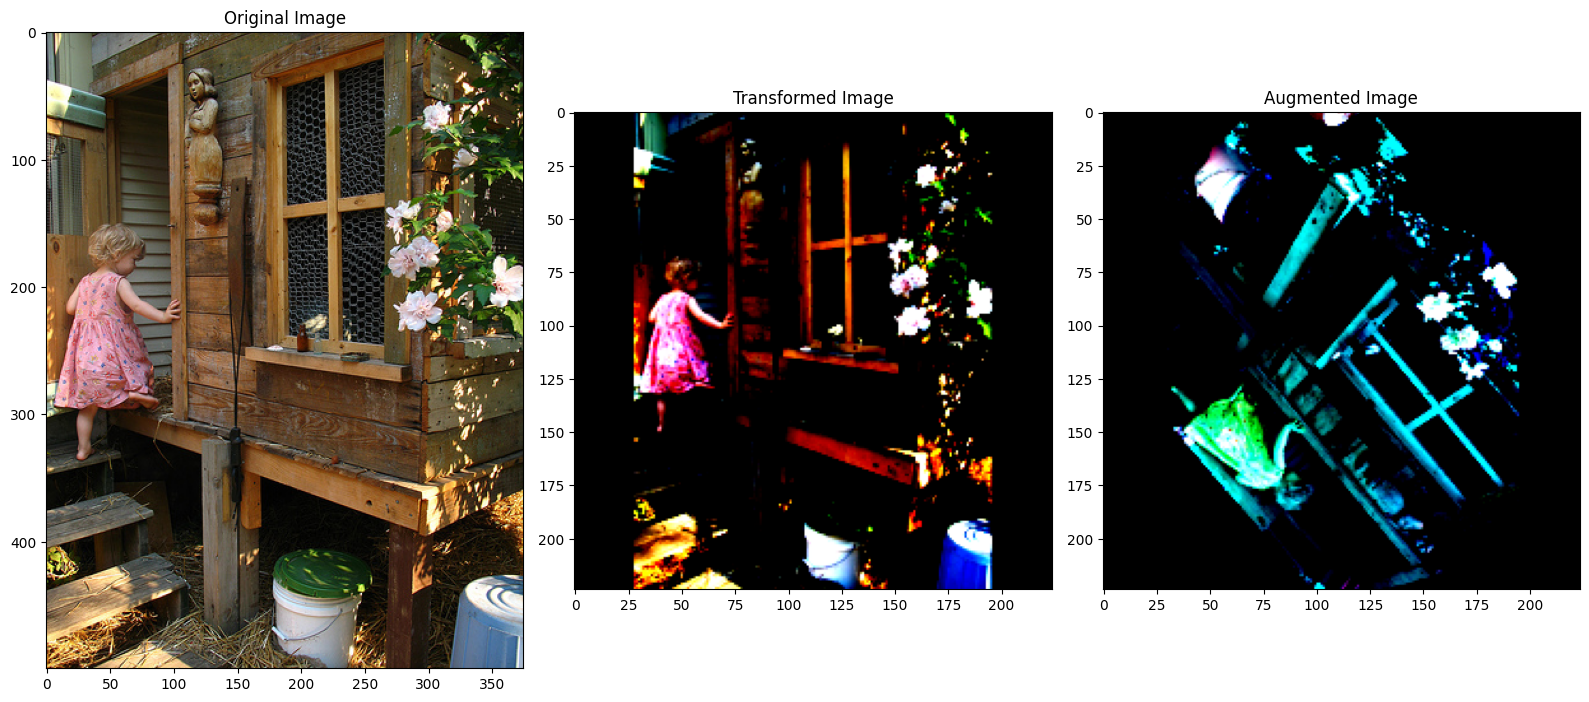

In [37]:
# Show transformation on sample image
image_id = flicker_data['image'][0]
image = flicker_data_explorer._read_image(image_id)
image_transformed = image_transformations(image)
image_transformed_augmented = image_transforms_augmented(image)

fig, ax = plt.subplots(1, 3, figsize=(16, 8))
ax[0].imshow(np.asarray(image))
ax[0].set_title('Original Image')
ax[1].imshow(np.transpose(image_transformed, (1, 2, 0)))
ax[1].set_title('Transformed Image')
ax[2].imshow(np.transpose(image_transformed_augmented, (1, 2, 0)))
ax[2].set_title('Augmented Image')
plt.tight_layout()
plt.show()



---

# 4 PreProcessing von Captions
Die gezeigte Python-Klasse `PreprocessCaption` dient der Vorverarbeitung von Bildunterschriften (captions) in natürlicher Sprache.

Konstruktor `__init__`:

Der Konstruktor dieser Klasse wird beim Erstellen eines Objekts aufgerufen und hat einen optionalen Parameter `threshold`, der auf den Wert 2 eingestellt ist. Dieser Schwellenwert dient dazu, die Wörter in der Vokabelliste zu filtern. Die Klasse hat außerdem einige Instanzvariablen, darunter `threshold`, `vocab`, `word_to_index`, `index_to_word`, `freq_dist` und `special_tokens`. 

- `threshold`: Der Schwellenwert zur Auswahl der Wörter im Vokabular basierend auf ihrer Häufigkeit.
- `vocab`: Eine Liste, die das Vokabular enthält.
- `word_to_index`: Ein Wörterbuch, das Wörter auf ihre Indexpositionen im Vokabular abbildet.
- `index_to_word`: Ein Wörterbuch, das Indexpositionen auf die entsprechenden Wörter im Vokabular abbildet.
- `freq_dist`: Eine Instanz von `FreqDist` aus der NLTK-Bibliothek, die die Häufigkeit der Wörter im Text speichert.
- `special_tokens`: Eine Liste von speziellen Tokens wie '<START>', '<END>', '<PAD>' und '<UNK>', die oft in NLP-Aufgaben verwendet werden.

`create_vocabulary`:

Diese Methode erstellt das Vokabular basierend auf den übergebenen Daten in Form eines Pandas DataFrame. Sie tokenisiert zuerst alle Bildunterschriften, filtert Wörter nach ihrer Häufigkeit unter Verwendung des Schwellenwerts und fügt schließlich die speziellen Tokens zum Vokabular hinzu. Das Ergebnis wird in den Instanzvariablen `vocab`, `word_to_index` und `index_to_word` gespeichert.

`get_vocab`:

Diese Methode gibt das Vokabular als Liste von Wörtern zurück.

`get_vocab_size`:

Diese Methode gibt die Größe des Vokabulars zurück, dh die Anzahl der eindeutigen Wörter im Vokabular.

`get_word_to_index`:

Diese Methode gibt das Wörterbuch zurück, das Wörter auf ihre Indexpositionen im Vokabular abbildet.

`get_index_to_word`:

Diese Methode gibt das Wörterbuch zurück, das Indexpositionen auf die entsprechenden Wörter im Vokabular abbildet.

`caption_to_tokens`:

Diese Methode konvertiert eine Bildunterschrift in eine Liste von Token-Indizes unter Verwendung des erstellten Vokabulars. Die Tokens werden in der Reihenfolge '<START>', gefolgt von den Token-Indizes der Wörter in der Bildunterschrift und schließlich '<END>' zurückgegeben.

`tokens_to_caption`:

Diese Methode konvertiert eine Liste von Token-Indizes zurück in eine menschenlesbare Bildunterschrift, indem sie die Wörter aus dem Vokabular extrahiert und sie in der richtigen Reihenfolge anordnet, bis '<END>' erreicht wird. Dabei werden spezielle Tokens wie '<START>' und '<END>' ignoriert.

Die Klasse `PreprocessCaption` ermöglicht es, Textdaten für die Verwendung in Machine Learning- oder Deep Learning-Modellen vorzubereiten, insbesondere für Aufgaben im Bereich des maschinellen Sehens (Computer Vision), bei denen Bildunterschriften verarbeitet werden müssen.


In [11]:
class PreprocessCaption:
    def __init__(self, threshold: int = 2):
        self.threshold = threshold
        self.vocab = []
        self.word_to_index = {}
        self.index_to_word = {}
        self.freq_dist = None
        self.special_tokens = ['<START>', '<END>', '<PAD>', '<UNK>']

    def get_vocab(self) -> List[str]:
        return self.vocab

    def get_vocab_size(self) -> int:
        return len(self.vocab)
    
    def get_word_to_index(self) -> dict:
        return self.word_to_index
    
    def get_index_to_word(self) -> dict:
        return self.index_to_word

    def create_vocabulary(self, data: pd.DataFrame) -> None:
        all_captions = " ".join(data["caption"].values)
        words = word_tokenize(all_captions.lower())
        words = [word for word in words if word.isalpha()]
        self.freq_dist = FreqDist(words)

        self.vocab = [word for word, freq in self.freq_dist.items() if freq >= self.threshold]
        self.vocab = self.special_tokens + self.vocab
        self.word_to_index = {word: idx for idx, word in enumerate(self.vocab)}
        self.index_to_word = {idx: word for idx, word in enumerate(self.vocab)}

    def caption_to_tokens(self, caption: str) -> List[int]:
        if not caption:
            return []
        tokens = word_tokenize(caption.lower())
        tokenized_caption = [self.word_to_index.get('<START>')]
    
        for token in tokens:
            tokenized_caption.append(self.word_to_index.get(token, self.word_to_index.get('<UNK>')))
    
        tokenized_caption.append(self.word_to_index.get('<END>'))
        return tokenized_caption

    def tokens_to_caption(self, tokens: List[int]) -> str:
        words = []
        for idx in tokens:
            word = self.index_to_word.get(idx)
            if word == '<END>':
                break
            if word and word not in self.special_tokens:
                words.append(word)
        return ' '.join(words)


## 4.1 Test: Preprocessing der Captions 

In [54]:
# Initialize VocabularyBuilder
caption_info = PreprocessCaption(threshold=2)

# Create vocabulary
caption_info.create_vocabulary(flicker_data)

# Get vocabulary and its size
vocab = caption_info.get_vocab()
vocab_size = caption_info.get_vocab_size()

print("Vocabulary Size:", vocab_size)
print("Vocabulary:", vocab)
print()

# Get word_to_index and index_to_word
word_to_index = caption_info.get_word_to_index()
index_to_word = caption_info.get_index_to_word()

print("Word to Index:", word_to_index)
print("Index to Word:", index_to_word)
print()

# Call caption_to_tokens and tokens_to_caption methods
caption = "A black 43$#1 dog is running towards 34 pebsi the 0.5 old grey 18 cat"
tokens = caption_info.caption_to_tokens(caption)
print("Tokens:", tokens)
print()

reconstructed_caption = caption_info.tokens_to_caption(tokens)
print("Reconstructed Caption:", reconstructed_caption)
print()

# get token from PAD
pad_token = word_to_index.get('<PAD>')
print("PAD Token:", pad_token)

Vocabulary Size: 5083
Vocabulary: ['<START>', '<END>', '<PAD>', '<UNK>', 'a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'playhouse', 'the', 'to', 'her', 'cabin', 'black', 'dog', 'and', 'spotted', 'are', 'fighting', 'playing', 'with', 'each', 'other', 'on', 'road', 'white', 'brown', 'spots', 'staring', 'at', 'street', 'two', 'dogs', 'different', 'breeds', 'looking', 'pavement', 'moving', 'toward', 'covered', 'paint', 'sits', 'front', 'painted', 'rainbow', 'hands', 'bowl', 'sitting', 'large', 'small', 'grass', 'plays', 'fingerpaints', 'canvas', 'it', 'there', 'pigtails', 'painting', 'young', 'outside', 'man', 'lays', 'bench', 'while', 'his', 'by', 'him', 'which', 'also', 'tied', 'sleeping', 'next', 'shirtless', 'lies', 'park', 'laying', 'holding', 'leash', 'ground', 'orange', 'hat', 'starring', 'something', 'wears', 'glasses', 'gauges', 'wearing', 'beer', 'can', 'pierced', 'ears', '

## 4.2 Test: Preprocessing der Captions mit Trim und Padding

In [82]:
caption_to_pad = "a girl running around a tree"
caption_to_trim = "A girl running around a tree while playing with a dog and cat in the great big field of grass and flowers next to the river"

print("Caption to Pad:", caption_to_pad)
print("Caption to Trim:", caption_to_trim)
print()

max_length = 20
caption_to_pad_tokens = caption_info.caption_to_tokens(caption_to_pad)
caption_to_trim_tokens = caption_info.caption_to_tokens(caption_to_trim)

print("Caption to Pad Tokenized:", caption_to_pad_tokens)
print("Caption to Trim Tokenized:", caption_to_trim_tokens)
print()

padded_caption = caption_to_pad_tokens + [pad_token] * (max_length - len(caption_to_pad_tokens))
trimmed_caption = caption_to_trim_tokens[:max_length]

print(f"Padded Caption: {padded_caption},\n Length: {len(padded_caption)}")
print(f"Trimmed Caption: {trimmed_caption},\n Length: {len(trimmed_caption)}")



Caption to Pad: a girl running around a tree
Caption to Trim: A girl running around a tree while playing with a dog and cat in the great big field of grass and flowers next to the river

Caption to Pad Tokenized: [0, 4, 17, 116, 237, 4, 168, 1]
Caption to Trim Tokenized: [0, 4, 17, 116, 237, 4, 168, 78, 34, 35, 4, 29, 30, 1165, 6, 24, 1748, 232, 175, 13, 65, 30, 1042, 86, 25, 24, 415, 1]

Padded Caption: [0, 4, 17, 116, 237, 4, 168, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 Length: 20
Trimmed Caption: [0, 4, 17, 116, 237, 4, 168, 78, 34, 35, 4, 29, 30, 1165, 6, 24, 1748, 232, 175, 13],
 Length: 20


---

# 5 Dataset Vorbereitung

In [59]:
class ImageCaptionDataset(Dataset):
    def __init__(self, dataframe, image_path, vocab_size, caption_processor, transform=None, max_length=20):
        self.dataframe = dataframe
        self.images_path = image_path
        self.vocab_size = vocab_size
        self.caption_processor = caption_processor
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iloc[idx]['image']
        image = Image.open(os.path.join(self.images_path, image_name)).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = self.dataframe.iloc[idx]['caption']
        caption_tokens = self.caption_processor.caption_to_tokens(caption)
        caption_tokens = caption_tokens[:self.max_length]

        # Pad the caption tokens to the maximum length or trim 
        if len(caption_tokens) < self.max_length:
            # padding
            caption_tokens = caption_tokens + [self.caption_processor.word_to_index["<PAD>"]] * (self.max_length - len(caption_tokens))
            caption_tokens.append(self.caption_processor.pad_token)
        else:
            # trimming
            caption_tokens = caption_tokens[:self.max_length]

        caption_tokens = torch.tensor(caption_tokens, dtype=torch.long)

        return image, caption_tokens

## 5.1 Test Dataset Vorbereitung

In [60]:
# Test ImageCaptionDataset
dataframe = flicker_data
image_path = image_path
vocab_size = vocab_size
caption_processor = caption_info
transform = None
max_length = 20

dataset = ImageCaptionDataset(dataframe, image_path, vocab_size, caption_processor, transform, max_length)
print("Dataset Size:", len(dataset))

# Get a sample from the dataset
image, caption = dataset[0]
print("Image:", image)
print("Caption:", caption)
print("Caption Size:", caption.size())



Dataset Size: 40455
Image: <PIL.Image.Image image mode=RGB size=375x500 at 0x22F4780C250>
Caption: tensor([ 0,  4,  5,  6,  4,  7,  8,  9, 10, 11,  4, 12, 13, 14,  6, 15,  3, 16,
         3,  1])
Caption Size: torch.Size([20])


## 5.2 Train-Validation-Test Split

In [61]:
unique_images = flicker_data["image"].unique()
print("Number of unique images:", len(unique_images))

train_images, val_test_images = train_test_split(unique_images, test_size=0.4, random_state=42)
val_images, test_images = train_test_split(val_test_images, test_size=0.5, random_state=42)

train_df = flicker_data[flicker_data["image"].isin(train_images)]
val_df = flicker_data[flicker_data["image"].isin(val_images)]
test_df = flicker_data[flicker_data["image"].isin(test_images)]

print(f"Train dataset contains {len(train_df)} items.")
print(f"Validation dataset contains {len(val_df)} items.")
print(f"Test dataset contains {len(test_df)} items.")




Number of unique images: 8091
Train dataset contains 24270 items.
Validation dataset contains 8090 items.
Test dataset contains 8095 items.


In [62]:
# Create datasets
train_dataset = ImageCaptionDataset(train_df, vocab_size, caption_info, image_transformations)
val_dataset = ImageCaptionDataset(val_df, vocab_size, caption_info, image_transformations)
test_dataset = ImageCaptionDataset(test_df, vocab_size, caption_info, image_transformations)

# print len of datasets
print(f"Train dataset contains {len(train_dataset)} items.")
print(f"Validation dataset contains {len(val_dataset)} items.")
print(f"Test dataset contains {len(test_dataset)} items.")



Train dataset contains 24270 items.
Validation dataset contains 8090 items.
Test dataset contains 8095 items.


## 5.3 DataLoader

In [63]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, shuffle=True)

In [64]:
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 12135
Number of batches in val_loader: 4045
Number of batches in test_loader: 4048


In [66]:
# get the first batch form the train_loader
images, captions = next(iter(train_loader))
print("Images:", images)
print("Images Size:", images.size())


TypeError: expected str, bytes or os.PathLike object, not int

--- 

# 6 CNN Encoder

In [68]:
class EncoderCNN(pl.LightningModule):
    def __init__(self, embedding_dim):
        super(EncoderCNN, self).__init__()
        self.embedding_dim = embedding_dim # define embedding dimension
        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Use ResNet-18 with pre-trained weights

        # freeze all layers except the last linear layer
        for param in self.resnet.parameters():
            param.requires_grad = False
        

        # overwrite the last layer
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, self.embedding_dim), 
                                       nn.BatchNorm1d(self.embedding_dim, momentum=0.01))

    def forward(self, images):
        features = self.resnet(images)
        return features
    

## 6.1 Test CNN Encoder

In [70]:
# initialize encoder
encoder = EncoderCNN(embedding_dim=128)
encoder

EncoderCNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

---

# 7 LSTM Decoder

In [72]:
class DecoderLSTM(pl.LightningModule):
    def __init__(self, embedding_dim, hidden_size, vocab_size, num_layers=1):
        super(DecoderLSTM, self).__init__()

        # define the properties
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # define the layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)


    def forward(self, features, captions):
        # Embed the captions
        embeddings = self.embedding(captions)
        # Concatenate the feature vectors and embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        # Pass the embeddings through the LSTM cells
        hiddens, _ = self.lstm(embeddings)
        # Pass the outputs through the linear layer
        outputs = self.linear(hiddens)
        return outputs
    
    def greedy_sample(self, features, max_length=20):
        output = []
        batch_size = features.size(0)
        hidden = None

        # Prepare the initial input for LSTM, which is the features tensor
        while len(output) < max_length:
            lstm_output, hidden = self.lstm(features, hidden)  # Pass the input through LSTM
            outputs = self.linear(lstm_output.squeeze(1)) # Pass the LSTM outputs through the linear layer
            predicted = outputs.argmax(1)  # Get the predicted word indices
            output.append(predicted.item())  # Append the predicted word index to the output list
            if predicted.item() == 1: # Break if <eos> token is predicted
                break
            features = self.embedding(predicted).unsqueeze(1)  # Prepare the input for the next time step

        return torch.tensor(output, device=self.device)


## 7.1 Test LSTM Decoder

In [73]:
# initialize decoder
decoder = DecoderLSTM(embedding_dim=128, hidden_size=128, vocab_size=vocab_size)
decoder

DecoderLSTM(
  (embedding): Embedding(5083, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=5083, bias=True)
)

---

# 8 Encoder-Decoder Model

In [75]:
class EncoderDecoder(pl.LightningModule):
    def __init__(self, embedding_dim, hidden_size, vocab_size, num_layers, train_loader, val_loader, test_loader, learning_rate = 0.001):
        super(EncoderDecoder, self).__init__()
        self.encoder = EncoderCNN(embedding_dim)
        self.decoder = DecoderLSTM(embedding_dim, hidden_size, vocab_size, num_layers)

        # define hyperparameters
        self.save_hyperparameters()
        self.vocab_size = vocab_size

        self.learning_rate = learning_rate
        
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

    def forward(self, images):
        features = self.encoder(images)
        return features
    
    def training_step(self, batch, batch_idx):
        images, captions = batch
        features = self.forward(images)
        outputs = self.decoder(features, captions)

        captions_length = (captions != 1).sum(dim=1)    # Get the length of captions excluding padding tokens
        output = [outputs[i, :captions_length[i]] for i in range(len(captions_length))]  # Remove the predictions beyond the length of each caption
        output = torch.cat(output, dim=0) # Concatenate the outputs into a single tensor
        output = output.view(-1, self.vocab_size) # Reshape the outputs to match the shape of the targets

        captions = [captions[i, :captions_length[i]] for i in range(len(captions_length))] # Remove the captions beyond the length of each caption
        captions = torch.cat(captions, dim=0) # Concatenate the captions into a single tensor
        captions = captions.view(-1) # Reshape the captions to match the shape of the outputs

        loss = torch.nn.functional.cross_entropy(output, captions) # Calculate the cross-entropy loss

        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, captions = batch
        features = self.forward(images)
        outputs = self.decoder(features, captions)

        captions_length = (captions != 1).sum(dim=1)    # Get the length of captions excluding padding tokens
        output = [outputs[i, :captions_length[i]] for i in range(len(captions_length))] # Remove the predictions beyond the length of each caption
        output = torch.cat(output, dim=0)
        output = output.view(-1, self.vocab_size)

        captions = [captions[i, :captions_length[i]] for i in range(len(captions_length))] # Remove the captions beyond the length of each caption
        captions = torch.cat(captions, dim=0)
        captions = captions.view(-1)

        loss = torch.nn.functional.cross_entropy(output, captions) # Calculate the cross-entropy loss

        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate) # Use Adam optimizer with the specified learning rate
    
        




# 8.1 Test Encoder-Decoder Model

In [76]:
# initialize encoder-decoder
encoder_decoder = EncoderDecoder(embedding_dim=128, hidden_size=128, vocab_size=vocab_size, num_layers=1, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader)
encoder_decoder

EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): 